[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-mmlab/mmediting/blob/master/demo/matting_tutorial.ipynb)

# MMEditing Tutorial-Matting

Welcome to MMEditing! This is the official colab tutorial for using MMEditing for matting task. In this tutorial, you will learn to

* perform inference with a MMEditing mattor,
* train a new mattor with a new dataset.

Let's start!

## Install MMEditing

In [1]:
# Check PyTorch version
!pip list | grep torch

torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111


In [2]:
# Install mmcv-full dependency via openmim
!pip install openmim
!mim install mmcv-full

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42503 sha256=c41bc9591afafd3734467439bda16f8f719426f080a8cf8caf356e7ddc5ab4de
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.0 MB 10.8 MB/s 
     |████████████████████████████████| 190 kB 5.4 MB/s 


In [3]:
# Install mmediting from source
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting
!pip install -e .

Cloning into 'mmediting'...
remote: Enumerating objects: 9988, done.
remote: Counting objects: 100% (661/661), done.
remote: Compressing objects: 100% (428/428), done.
remote: Total 9988 (delta 291), reused 486 (delta 216), pack-reused 9327
Receiving objects: 100% (9988/9988), 5.99 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (6643/6643), done.
/content/mmediting
Obtaining file:///content/mmediting
  Running setup.py develop for mmedit


In [4]:
# Check MMEditing installation
import mmedit
print(mmedit.__version__)

0.13.0


## Perform inference with a MMEditing mattor

MMEditing already provides high level APIs to do inference and training.

In [5]:
# List all available IndexNet models
!mim search mmedit --config indexnet

--------------------------------------------------------------------------------
config id: indexnet
architecture                                  indexnet
comp1k/conn                                   44.8
comp1k/grad                                   25.5
comp1k/mse                                    0.012
comp1k/sad                                    45.6
config                                        configs/mattors/indexnet/indexn...
model                                         indexnet
paper                                         https://arxiv.org/abs/1908.00672
readme                                        configs/mattors/indexnet/README.md
training_data                                 comp1k
weight                                        https://download.openmmlab.com/...



In [6]:
# Download config and checkpoints for IndexNet to current working directory
!mkdir -p checkpoints
!mim download mmedit --config indexnet --dest checkpoints

processing indexnet...
  [####################################]  100%          
Successfully downloaded indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth to /content/mmediting/checkpoints
Successfully dumped indexnet.py to /content/mmediting/checkpoints


In [7]:
from mmedit.apis import matting_inference, init_model

# Choose to use a config and initialize the mattor
config = 'configs/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth'
# Initialize the recognizer
model = init_model(config, checkpoint, device='cuda:0')

load checkpoint from local path: checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth


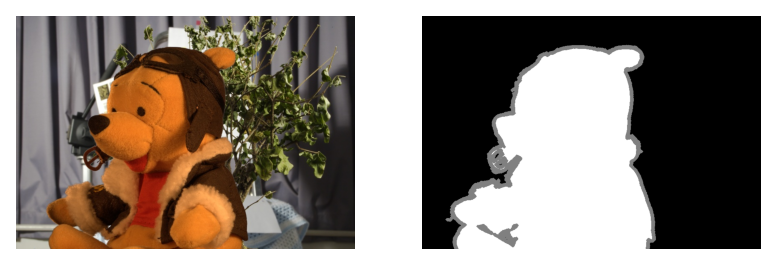

In [8]:
%matplotlib inline 
import mmcv
from matplotlib import pyplot as plt

# Sample images path
merged_path = './tests/data/merged/GT05.jpg'
trimap_path = './tests/data/trimap/GT05.png'

# Plot sample images
merged = mmcv.imread(merged_path)
trimap = mmcv.imread(trimap_path)
f, axarr = plt.subplots(1, 2)
f.dpi = 160
axarr[0].axis('off')
axarr[0].imshow(mmcv.bgr2rgb(merged))
axarr[1].axis('off')
axarr[1].imshow(trimap)

In [9]:
# Use the mattor to do inference
pred_alpha = matting_inference(model, merged_path, trimap_path) * 255

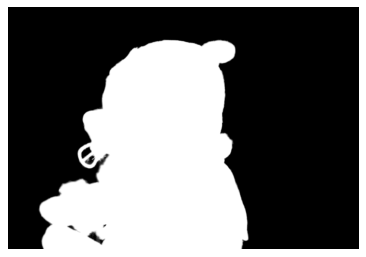

In [11]:
# Plot result
plt.gcf().dpi = 80
plt.axis('off')
plt.imshow(pred_alpha, cmap=plt.get_cmap('gray'))
plt.show()

In [12]:
# Save some GPU memory
del model

## Train a mattor on a customized dataset

To train a new mattor, there are usually three things to do:

1. Support a new dataset
2. Modify the config
3. Train a new mattor

### Support a new dataset

In this tutorial, we gives an example to convert the data into the format of existing datasets. 

<!-- TODO: Other methods and more advanced usages can be found in the [doc](TODO). -->

Firstly, let's download the only available open source matting dataset from [alphamatting.com](http://alphamatting.com/). 

In [13]:
!mkdir -p data/alphamatting/
!wget http://alphamatting.com/datasets/zip/input_training_lowres.zip -O data/alphamatting/input_training_lowres.zip
!wget http://alphamatting.com/datasets/zip/trimap_training_lowres.zip -O data/alphamatting/trimap_training_lowres.zip
!wget http://alphamatting.com/datasets/zip/gt_training_lowres.zip -O data/alphamatting/gt_training_lowres.zip

--2022-03-16 23:21:06--  http://alphamatting.com/datasets/zip/input_training_lowres.zip
Resolving alphamatting.com (alphamatting.com)... 128.131.167.210
Connecting to alphamatting.com (alphamatting.com)|128.131.167.210|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18218854 (17M) [application/zip]
Saving to: ‘data/alphamatting/input_training_lowres.zip’

data/alphamatting/i 100%[===================>]  17.37M  10.2MB/s    in 1.7s    

2022-03-16 23:21:08 (10.2 MB/s) - ‘data/alphamatting/input_training_lowres.zip’ saved [18218854/18218854]

--2022-03-16 23:21:08--  http://alphamatting.com/datasets/zip/trimap_training_lowres.zip
Resolving alphamatting.com (alphamatting.com)... 128.131.167.210
Connecting to alphamatting.com (alphamatting.com)|128.131.167.210|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375510 (367K) [application/zip]
Saving to: ‘data/alphamatting/trimap_training_lowres.zip’

data/alphamatting/t 100%[===================>

In [14]:
!unzip -o data/alphamatting/input_training_lowres.zip -d data/alphamatting/merged
!unzip -o data/alphamatting/trimap_training_lowres.zip -d data/alphamatting/trimap
!unzip -o data/alphamatting/gt_training_lowres.zip -d data/alphamatting/alpha

Archive:  data/alphamatting/input_training_lowres.zip
  inflating: data/alphamatting/merged/GT27.png  
  inflating: data/alphamatting/merged/GT01.png  
  inflating: data/alphamatting/merged/GT02.png  
  inflating: data/alphamatting/merged/GT03.png  
  inflating: data/alphamatting/merged/GT04.png  
  inflating: data/alphamatting/merged/GT05.png  
  inflating: data/alphamatting/merged/GT06.png  
  inflating: data/alphamatting/merged/GT07.png  
  inflating: data/alphamatting/merged/GT08.png  
  inflating: data/alphamatting/merged/GT09.png  
  inflating: data/alphamatting/merged/GT10.png  
  inflating: data/alphamatting/merged/GT11.png  
  inflating: data/alphamatting/merged/GT12.png  
  inflating: data/alphamatting/merged/GT13.png  
  inflating: data/alphamatting/merged/GT14.png  
  inflating: data/alphamatting/merged/GT15.png  
  inflating: data/alphamatting/merged/GT16.png  
  inflating: data/alphamatting/merged/GT17.png  
  inflating: data/alphamatting/merged/GT18.png  
  inflating: da

Then we create the annotation file for training data.

In [15]:
num_file = 27
num_training = 20  # use 20 samples for training, 7 for test

training_ann = list()
for i in range(num_training):
  ann = dict()
  ann['merged_path'] = f'merged/GT{i+1:02d}.png'
  ann['alpha_path'] = f'alpha/GT{i+1:02d}.png'
  # since data from alphamatting.com is not composited, we use original image 
  # as fg and bg
  ann['fg_path'] = ann['merged_path']
  ann['bg_path'] = ann['merged_path']
  training_ann.append(ann)

mmcv.dump(training_ann, './data/alphamatting/training_list.json')

Let's create the annotation file for test data in the same way.

In [16]:
num_trimap = 1
test_ann = list()
for i in range(num_training, num_file):
  for j in range(num_trimap):
    ann = dict()
    ann['merged_path'] = f'merged/GT{i+1:02d}.png'
    ann['trimap_path'] = f'trimap/Trimap{j+1}/GT{i+1:02d}.png'
    ann['alpha_path'] = f'alpha/GT{i+1:02d}.png'
    test_ann.append(ann)

mmcv.dump(test_ann, './data/alphamatting/test_list.json')

### Modify the config

In the next step, we need to modify the config for the training. To accelerate the process, we finetune a mattor using a pre-trained mattor.

In [17]:
from mmcv import Config
cfg = Config.fromfile('./configs/mattors/indexnet/indexnet_mobv2_1x16_78k_comp1k.py')

Given a config that trains a IndexNet model on Adobe Composition-1k dataset, we need to modify some values to use it for training IndexNet on the dataset we just created.

In [18]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.data.train.type = 'AdobeComp1kDataset'
cfg.data.train.ann_file = './data/alphamatting/training_list.json'
cfg.data.train.data_prefix = './data/alphamatting/'

cfg.data.val.type = 'AdobeComp1kDataset'
cfg.data.val.ann_file = './data/alphamatting/test_list.json'
cfg.data.val.data_prefix = './data/alphamatting/'

cfg.data.test.type = 'AdobeComp1kDataset'
cfg.data.test.ann_file = './data/alphamatting/test_list.json'
cfg.data.test.data_prefix = './data/alphamatting/'

# We can use the pre-trained IndexNet model
cfg.load_from = './checkpoints/indexnet_mobv2_1x16_78k_comp1k_SAD-45.6_20200618_173817-26dd258d.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps/indexnet'

# Use smaller batch size for training
cfg.data.samples_per_gpu = 1
cfg.data.workers_per_gpu = 1

# The original learning rate (LR) is set for batch size 16 with 1 GPU.
# We reduce the lr by a factor of 4 since we reduce the batch size.
cfg.optimizers.lr = cfg.optimizers.lr / 4
cfg.total_iters = 50
cfg.lr_config = None

# Evaluate every 20 iterations
cfg.evaluation.interval = 20
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 40
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpus = 1

### Train a new mattor

Finally, lets initialize the dataset and mattor, then train a new mattor!

In [19]:
import os.path as osp

from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the mattor
model = build_model(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train the model
train_model(model, datasets, cfg, distributed=False, validate=True)

2022-03-16 23:21:12,470 - root - INFO - load model from: open-mmlab://mmedit/mobilenet_v2
2022-03-16 23:21:12,477 - mmedit - INFO - load checkpoint from openmmlab path: open-mmlab://mmedit/mobilenet_v2
Downloading: "https://download.openmmlab.com/mmediting/third_party/mobilenet_v2.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2.pth


  0%|          | 0.00/7.07M [00:00<?, ?B/s]

2022-03-16 23:21:15,580 - mmedit - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: index_layers.0.index_blocks.0.0.conv.weight, index_layers.0.index_blocks.0.0.bn.weight, index_layers.0.index_blocks.0.0.bn.bias, index_layers.0.index_blocks.0.0.bn.running_mean, index_layers.0.index_blocks.0.0.bn.running_var, index_layers.0.index_blocks.0.1.conv.weight, index_layers.0.index_blocks.1.0.conv.weight, index_layers.0.index_blocks.1.0.bn.weight, index_layers.0.index_blocks.1.0.bn.bias, index_layers.0.index_blocks.1.0.bn.running_mean, index_layers.0.index_blocks.1.0.bn.running_var, index_layers.0.index_blocks.1.1.conv.weight, index_layers.0.index_blocks.2.0.conv.weight, index_layers.0.index_blocks.2.0.bn.weight, index_layers.0.index_blocks.2.0.bn.bias, index_layers.0.index_blocks.2.0.bn.running_mean, index_layers.0.index_blocks.2.0.bn.running_var, index_layers.0.index_blocks.2.1.conv.weight, index_layers.0.index_blocks.3.0.conv.weight, index_la

RuntimeError: ignored

### Understand the log

From the log, we can have a basic understanding the training process and know how well the mattor is trained.

Firstly, the MobileNetV2 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more costly. The log shows that all the weights of the MobileNetV2 backbone are loaded while some parts of the model are missing in the loaded weight. But no worries! These parts have a larger learning rate than the pretrained parts (You can print out `cfg.optimizers` to see the pretrained parts with name prefix `encoder.layers` have a `lr_mult=0.01`).

Secondly, after training, the mattor is evaluated by the default evaluation. The results show that the mattor achieves lower and lower SAD along the training process,

Not bad!

## Test the trained mattor

After finetuning the recognizer, let's check the prediction results!

In [ ]:
from mmedit.apis import single_gpu_test
from mmedit.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader and model
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])

# Perform the test with single gpu. Saving result images by setting
# save_image and save_path arguments. The two arguments will be passed
# to model.forword_test() where images are saved.
# See https://github.com/open-mmlab/mmediting/blob/8b5c0c5f49e60fd6ab0503031b62dee7832faf72/mmedit/models/mattors/indexnet.py#L72.
outputs = single_gpu_test(model, data_loader, save_image=True, save_path='./tutorial_exps/indexnet/results')

# Pop out some unnecessary arguments
eval_config = cfg.evaluation
eval_config.pop('interval')
eval_config.pop('save_image', False)
eval_config.pop('save_path', None)

eval_res = dataset.evaluate(outputs, **eval_config)
print()  # endline of progress bar
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

The result is the same as the last validation! This is because we use the same data for test and validation. Next, let's take a look at the visual results of the test! The results are saved in the directory `tutorial_exps/indexnet/results` that we specified.

In [ ]:
!ls tutorial_exps/indexnet/results

Plot the sample `GT21`:

In [ ]:
# Sample images path
merged_path = './data/alphamatting/merged/GT21.png'
trimap_path = './data/alphamatting/trimap/Trimap1/GT21.png'
alpha_path = './tutorial_exps/indexnet/results/GT21.png'

# Plot sample images
merged = mmcv.imread(merged_path)
trimap = mmcv.imread(trimap_path)
alpha = mmcv.imread(alpha_path)
f, axarr = plt.subplots(1, 3)
f.dpi = 240
axarr[0].axis('off')
axarr[0].imshow(mmcv.bgr2rgb(merged))
axarr[1].axis('off')
axarr[1].imshow(trimap)
axarr[2].axis('off')
axarr[2].imshow(alpha)
plt.show()

Congratulations! You've done the tutorial of using MMEditing for matting task. Go to [Getting Started page](https://github.com/open-mmlab/mmediting/blob/master/docs/en/getting_started.md) for more usage of MMEditing and start to train your own mattor!